In [1]:
import numpy as np
import sys
import os
import warnings

In [2]:
notebooks_dir = get_ipython().starting_dir
sys.path.append(os.path.join(notebooks_dir, '..', '.'))

In [3]:
from src.scripts.ode.generate_data import generate_data
from src.lib.simulation_manager import Oscilator, LorenzAttractor, RoselerAttractor
from src.scripts.ode.fit_odefind import fit_and_save_coeffs
from src.scripts.config import data_path, results_path
from src.scripts.ode.integrate_predict import integrate_predict_smape
from src.scripts.ode.plot_predictions import plot_predictions , plot_times

## Generate data

In [4]:
gen_data = [['LorenzAttractor', LorenzAttractor,[{'sigma': 10, 'rho': 28, 'beta': 8.0 / 3}]],
            ['rosseler', RoselerAttractor,[{'a': 0.52, 'b': 2, 'c': 4}]],
            ['oscilator',Oscilator,[{'a': 0.1, 'b': -1, 'c': 1, 'd': 0}] ]
           ]
for data_experiment_name, model_class, list_model_parms in gen_data:
    
    folder_data = generate_data(
                    num_experiments_per_param=20,
                    num_time_steps=5000,
                    dt=0.01,

                    data_experiment_name=data_experiment_name,
                    model_class=model_class,
                    list_model_params=list_model_parms
                )
    print(f'Data was saved in {folder_data}')

Data was saved in /home/yamila/projects/rte2020/ret-ode/examples/../data2/LorenzAttractor
Data was saved in /home/yamila/projects/rte2020/ret-ode/examples/../data2/rosseler
Data was saved in /home/yamila/projects/rte2020/ret-ode/examples/../data2/oscilator


## Experiments setting

In [5]:
system = 'oscilator'
obs_vars = ['x']
targets = [1,2,3] # for odefind, gpomo always fits targets 2 and 3
maxpolys = [3]

In [6]:
# system = 'rosseler'
# obs_vars = ['x']
# targets = [2,3]
# maxpolys = [3]

In [7]:
# system = 'rosseler'
# obs_vars = ['y']
# targets = [2,3]
# maxpolys = [3]

In [8]:
# system = 'LorenzAttractor'
# obs_vars = ['x']
# targets = [2,3]
# maxpolys = [3]

## Fit L-ODEfind models

In [9]:
model = system
out = system
warnings.filterwarnings("ignore")
fit_and_save_coeffs(model, out, targets=targets, maxpolys=maxpolys, obs_vars=obs_vars, testsize=200)


## Fit GPoMo models
We use R to fit GPoMo models

In [10]:
d_path = str(data_path.resolve()) + f'/{system}/'
r_path = str(results_path.resolve()) + f"/{system}_{'_'.join(obs_vars)}/"
v = '_'.join(obs_vars)

In [11]:
%cd ..
%cd r_scripts
! Rscript gpomo_predition_1_var_observed.R $d_path $r_path $v

/home/yamila/projects/rte2020/ret-ode
/home/yamila/projects/rte2020/ret-ode/r_scripts
Loading required package: GPoM
Loading required package: deSolve
Loading required package: rgl
[1] "/home/yamila/projects/rte2020/ret-ode/data2/oscilator/"
[1] "/home/yamila/projects/rte2020/ret-ode/results2/oscilator_x/"
[1] "x"
[1] "/home/yamila/projects/rte2020/ret-ode/data2/oscilator/"
[1] "--------------------------"
[1] "solution_params_0_init_cond_0.csv"
[1] "--------------------------"
[1] "Doing steps: 40 max time derivative 2 poly degree 3"
### For Istep = 10 (max: 40), models to test: 10 / 10 
### For Istep = 20 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.15s  
### For Istep = 40 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.21s  
### Number of unclassified models: 10 / 10 
[1] "Time: 0.805906057357788"
[1] "Doing steps: 40 max time derivative 3 poly degree 3"
### For Istep = 10 (max: 40), models to test: 17 / 17 
### For Istep = 20 (max: 40), models to test: 17 / 17

### For Istep = 20 (max: 40), models to test: 17 / 17. Runtime: ~ 0h 0min 0.35s  
### For Istep = 40 (max: 40), models to test: 17 / 17. Runtime: ~ 0h 0min 0.68s  
### Number of unclassified models: 17 / 17 
[1] "Time: 2.07699799537659"
[1] "--------------------------"
[1] "solution_params_0_init_cond_18.csv"
[1] "--------------------------"
[1] "Doing steps: 40 max time derivative 2 poly degree 3"
### For Istep = 10 (max: 40), models to test: 10 / 10 
### For Istep = 20 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.11s  
### For Istep = 40 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.21s  
### Number of unclassified models: 10 / 10 
[1] "Time: 0.701768159866333"
[1] "Doing steps: 40 max time derivative 3 poly degree 3"
### For Istep = 10 (max: 40), models to test: 17 / 17 
### For Istep = 20 (max: 40), models to test: 17 / 17. Runtime: ~ 0h 0min 0.34s  
### For Istep = 40 (max: 40), models to test: 17 / 17. Runtime: ~ 0h 0min 0.78s  
### Number of unclassified m

### Number of unclassified models: 17 / 17 
[1] "Time: 1.85161399841309"
There were 50 or more warnings (use warnings() to see the first 50)


## Integrate, predict and compute SMAPE for L-ODEfind and GPoMo models

In [12]:
odefind_model = f"{system}_{'_'.join(obs_vars)}_Odefind"
gpomo_model = f"{system}_{'_'.join(obs_vars)}"
for model_data, model_results in [[system,gpomo_model],[system, odefind_model]]:
    df = integrate_predict_smape(original_data=model_data, results_folder=model_results,
                             time_horizons=np.arange(1, 200, dtype=int),
                             testsize=200, one=False, verbose=True)


solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_0-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_3-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_1-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_15-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_5-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_16-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_11-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_12-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_18-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_2-steps_40.csv
D

solution-pdefind_coefs-vars_x-dmax_1-poly_3-params_0-init_cond_3-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_4-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_12-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_16-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_14-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_6-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_3-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_1-poly_3-params_0-init_cond_14-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_1-poly_3-params_0-init_cond_1-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_1-step

## Plot predictions comparison

In [13]:
# Some plotting params
ymax = 0.5
targets = [1, 2]
time_horizons = np.arange(5, 196, 5)

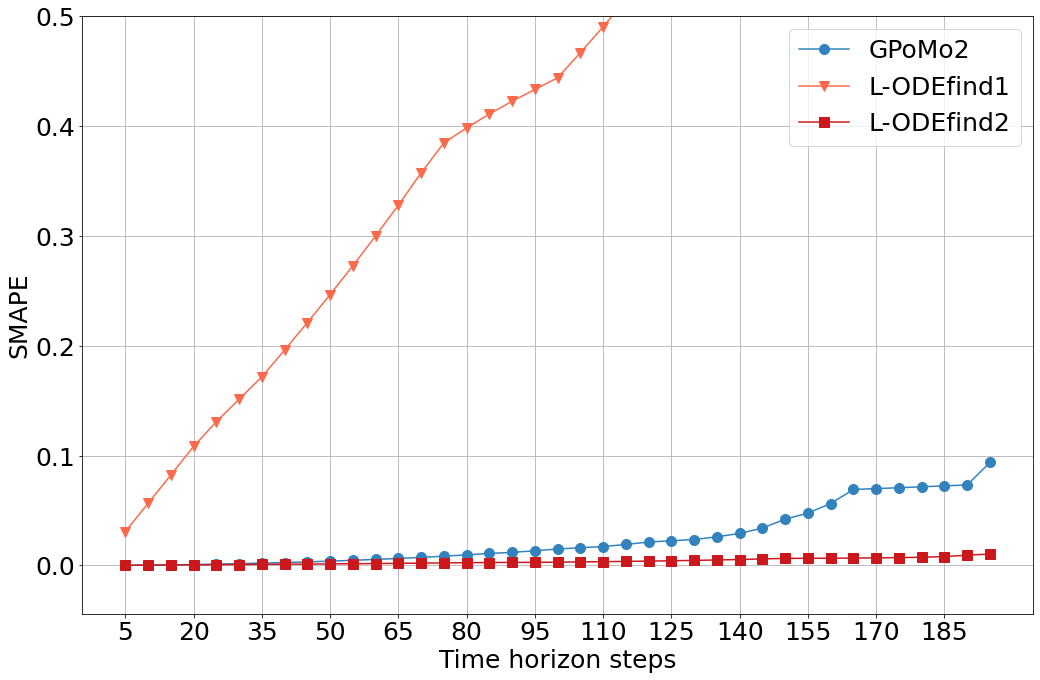

In [14]:
plot_data = plot_predictions(gpomo_model, time_horizons, odefind_model, ymax, targets_to_plot=targets)


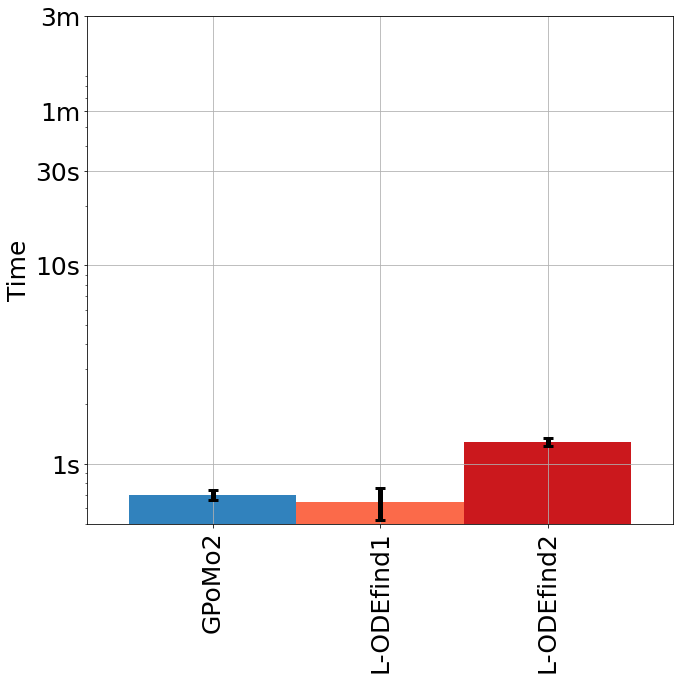

In [15]:
times_data = plot_times(gpomo_model, odefind_model,targets_to_plot=targets)